In [1]:
from __future__ import print_function, division
import scipy
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from instancenormalization import InstanceNormalization

from atten_Unet_5 import att_unet 
import matplotlib.pyplot as plt
from data_loader2 import data_loader
from data_loader2 import load_data
import numpy as np
import os, random, sys, datetime

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# ramdom_seed = 5198
# np.random.seed(ramdom_seed)
# random.seed(ramdom_seed)
# os.environ['PYTHONHASHSEED'] = str(ramdom_seed)

In [2]:
class CycleGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 256
        self.img_cols = 256
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        # Configure data loader
        data_path1 = r'D:\DATA\ENDOSCOPY\00_vrcaps_recoding_data_simulation\20210624_delete\train\20210625_sub01\Recordings'
        data_path2 = r'D:\DATA\ENDOSCOPY\yonsei\normal_crop'
        self.batch_size = 6
        self.data1 = load_data(data_path1)
        self.data2 = load_data(data_path2)
        self.data_loader = data_loader(self.data1, self.data2, self.batch_size, aug = True)
        self.dataset_name = 'images'

        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        self.gf = 32
        self.df = 64

        # Loss weights
        self.lambda_cycle = 10.0                    # Cycle-consistency loss
        self.lambda_id = 0.1 * self.lambda_cycle    # Identity loss

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminators
        self.d_A = self.build_discriminator()
        self.d_B = self.build_discriminator()
        self.d_A.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])
        self.d_B.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generators
        #-------------------------

        # Build the generators
        self.g_AB = att_unet(self.img_rows, self.img_cols, data_format='channels_last')
        self.g_BA = att_unet(self.img_rows, self.img_cols, data_format='channels_last')

        # Input images from both domains
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # Translate images to the other domain
        fake_B = self.g_AB(img_A)
        fake_A = self.g_BA(img_B)
        # Translate images back to original domain
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)
        # Identity mapping of images
        img_A_id = self.g_BA(img_A)
        img_B_id = self.g_AB(img_B)

        # For the combined model we will only train the generators
        self.d_A.trainable = False
        self.d_B.trainable = False

        # Discriminators determines validity of translated images
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)

        # Combined model trains generators to fool discriminators
        self.combined = Model(inputs=[img_A, img_B],
                              outputs=[ valid_A, valid_B,
                                        reconstr_A, reconstr_B,
                                        img_A_id, img_B_id ])
        self.combined.compile(loss=['mse', 'mse',
                                    'mae', 'mae',
                                    'mse', 'mse'],
                            loss_weights=[  1, 1,
                                            self.lambda_cycle, self.lambda_cycle,
                                            self.lambda_id, self.lambda_id ],
                            optimizer=optimizer)


    def build_discriminator(self):

        def d_layer(layer_input, filters, f_size=4, normalization=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if normalization:
                d = InstanceNormalization()(d)
            return d

        img = Input(shape=self.img_shape)

        d1 = d_layer(img, self.df, normalization=False)
        d2 = d_layer(d1, self.df*2)
        d3 = d_layer(d2, self.df*4)
        d4 = d_layer(d3, self.df*8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model(img, validity)

    def train(self, epochs, sample_interval=50):

        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((self.batch_size,) + self.disc_patch)
        fake = np.zeros((self.batch_size,) + self.disc_patch)

        for epoch in range(epochs):
            for batch_i in range(150):
                imgs_A, imgs_B = next(self.data_loader)
                # ----------------------
                #  Train Discriminators
                # ----------------------

                # Translate images to opposite domain
                fake_B = self.g_AB.predict(imgs_A)
                fake_A = self.g_BA.predict(imgs_B)

                # Train the discriminators (original images = real / translated = Fake)
                dA_loss_real = self.d_A.train_on_batch(imgs_A, valid)
                dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)
                dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

                dB_loss_real = self.d_B.train_on_batch(imgs_B, valid)
                dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)
                dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

                # Total disciminator loss
                d_loss = 0.5 * np.add(dA_loss, dB_loss)


                # ------------------
                #  Train Generators
                # ------------------

                # Train the generators
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B],
                                                        [valid, valid,
                                                        imgs_A, imgs_B,
                                                        imgs_A, imgs_B])

                elapsed_time = datetime.datetime.now() - start_time

                # Plot the progress
                if batch_i % 100 ==0:
                    print ("[Epoch %d/%d] [Batch %d] [D loss: %f, acc: %3d%%] [G loss: %05f, adv: %05f, recon: %05f, id: %05f] time: %s " \
                                                                        % ( epoch, epochs,
                                                                            batch_i,
                                                                            d_loss[0], 100*d_loss[1],
                                                                            g_loss[0],
                                                                            np.mean(g_loss[1:3]),
                                                                            np.mean(g_loss[3:5]),
                                                                            np.mean(g_loss[5:6]),
                                                                            elapsed_time))

                # If at save interval => save generated image samples
                if batch_i % sample_interval == 0:
                    self.sample_images(epoch, batch_i)
            if epoch % 10 == 0:
                gan.g_AB.save_weights('saved_model/AB_%04d.h5'%epoch)
                gan.g_BA.save_weights('saved_model/BA_%04d.h5'%epoch)
        
    def sample_images(self, epoch, batch_i):
        os.makedirs('images/%s' % self.dataset_name, exist_ok=True)
        r, c = 2, 3

        imgs_A, imgs_B = next(self.data_loader)

        # Demo (for GIF)
        #imgs_A = self.data_loader.load_img('datasets/apple2orange/testA/n07740461_1541.jpg')
        #imgs_B = self.data_loader.load_img('datasets/apple2orange/testB/n07749192_4241.jpg')

        # Translate images to the other domain
        fake_B = self.g_AB.predict(imgs_A[0:1])
        fake_A = self.g_BA.predict(imgs_B[0:1])
        # Translate back to original domain
        reconstr_A = self.g_BA.predict(fake_B)
        reconstr_B = self.g_AB.predict(fake_A)

        gen_imgs = np.concatenate([imgs_A[0:1], fake_B, reconstr_A, imgs_B[0:1], fake_A, reconstr_B])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        plt.figure(figsize=(15,10))
        plt.subplot(231)
        plt.imshow(gen_imgs[0])
        plt.subplot(232)
        plt.imshow(gen_imgs[1])
        plt.subplot(233)
        plt.imshow(gen_imgs[2])
        plt.subplot(234)
        plt.imshow(gen_imgs[3])
        plt.subplot(235)
        plt.imshow(gen_imgs[4])
        plt.subplot(236)
        plt.imshow(gen_imgs[5])
        plt.tight_layout()
        plt.savefig("images/%s/%04d_%04d.png" % (self.dataset_name, epoch, batch_i))
        plt.close()
        

In [3]:
gan = CycleGAN()

100%|██████████| 685/685 [00:06<00:00, 101.53it/s]


In [4]:
gan.train(epochs=200, sample_interval=100)

[Epoch 0/200] [Batch 0] [D loss: 12.251261, acc:  54%] [G loss: 48.408470, adv: 16.284626, recon: 0.724377, id: 0.687152] time: 0:00:36.181536 
[Epoch 0/200] [Batch 100] [D loss: 0.493621, acc:   7%] [G loss: 3.342554, adv: 0.616946, recon: 0.096543, id: 0.073101] time: 0:03:12.839591 
[Epoch 1/200] [Batch 0] [D loss: 0.362621, acc:  29%] [G loss: 3.735363, adv: 0.691148, recon: 0.107989, id: 0.137533] time: 0:04:32.454047 
[Epoch 1/200] [Batch 100] [D loss: 0.552391, acc:   9%] [G loss: 2.721480, adv: 0.466244, recon: 0.076285, id: 0.151360] time: 0:07:03.496780 
[Epoch 2/200] [Batch 0] [D loss: 0.397191, acc:  24%] [G loss: 2.487226, adv: 0.454807, recon: 0.070139, id: 0.089655] time: 0:08:19.542775 
[Epoch 2/200] [Batch 100] [D loss: 0.329447, acc:  35%] [G loss: 2.210384, adv: 0.466734, recon: 0.054515, id: 0.119331] time: 0:10:59.285031 
[Epoch 3/200] [Batch 0] [D loss: 0.330025, acc:  29%] [G loss: 2.289338, adv: 0.443241, recon: 0.061514, id: 0.103549] time: 0:12:17.513181 
[Epo

In [9]:
gan.g_AB.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 256, 256, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
instance_normalization_6 (Insta (None, 256, 256, 32) 2           conv2d_10[0][0]                  
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 256, 256, 32) 9248        instance_normalization_6[0][0]   
____________________________________________________________________________________________

In [4]:
outputlayer = gan.g_AB.get_layer('activation_7').output
attention = Model(gan.g_AB.inputs, outputlayer)

In [8]:
data_path1 = r'D:\DATA\ENDOSCOPY\00_vrcaps_recoding_data_simulation\20210625\train\20210625_sub01\Recordings'
data1 = load_data(data_path1)

100%|██████████| 1569/1569 [00:03<00:00, 445.41it/s]


In [20]:
for i in range(0, len(data1),20):
    predict = attention.predict(data1[i:i+1])
    plt.figure(figsize=(10,20))
    plt.subplot(3,1,1)
    plt.imshow(data1[i])
    plt.subplot(3,1,2)
    plt.imshow(predict[0])

    imgA = data1[i:i+1]/127.5 -1
    predictB = gan.g_AB.predict(imgA)
    img_trans = 0.5 * predictB[0,...] + 0.5
    img_trans = np.clip((img_trans * 255).astype(np.uint8), 0, 255)
    plt.subplot(3,1,3)
    plt.imshow(img_trans)
    plt.savefig(os.path.join('images/attention_img', f'{i}.png'), dpi=300)
    plt.close()

In [6]:
import cv2
import matplotlib.pyplot as plt
import glob, os, tqdm

 14%|█▍        | 1687/12008 [00:05<00:30, 335.58it/s]


KeyboardInterrupt: 

In [4]:
gan.g_AB.load_weights('saved_model/AB_0170.h5')

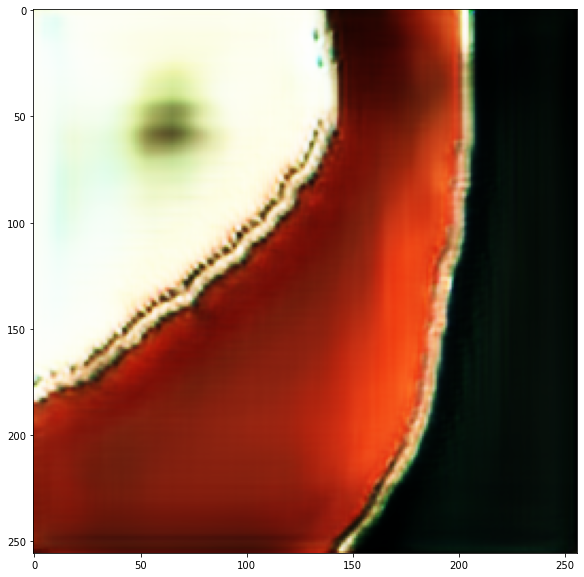

In [9]:
img = cv2.cvtColor(cv2.imread('test2.png'),cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256,256))/127.5 - 1
predictB = gan.g_AB.predict(img[np.newaxis,...])
img_trans = 0.5 * predictB[0,...] + 0.5
plt.figure(figsize=(10,10))
plt.imshow(img_trans)
plt.show()

In [7]:
all_data = []
data_list = glob.glob(r'D:\DATA\ENDOSCOPY\00_vrcaps_recoding_data_simulation\20210624\*' + '/*/Recordings/*.png')
for tmp in tqdm.tqdm(data_list): 
    img = cv2.cvtColor(cv2.imread(tmp),cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256,256))/127.5 - 1
    predictB = gan.g_AB.predict(img[np.newaxis,...])
    img_trans = 0.5 * predictB[0,...] + 0.5
    img_trans = np.clip((img_trans * 255).astype(np.uint8), 0, 255)
    cv2.imwrite(os.path.join(tmp.replace('Recordings', 'trans3')), cv2.cvtColor(img_trans, cv2.COLOR_RGB2BGR))

100%|██████████| 17172/17172 [15:56<00:00, 17.95it/s]


In [7]:


all_data = []
data_list = glob.glob(r'D:\DATA\ENDOSCOPY\00_vrcaps_recoding_data_simulation\20210624_delete\im\Recordings\*.png')
for tmp in tqdm.tqdm(data_list): 
    img = cv2.cvtColor(cv2.imread(tmp),cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256,256))/127.5 - 1
    predictB = gan.g_AB.predict(img[np.newaxis,...])
    img_trans = 0.5 * predictB[0,...] + 0.5
    img_trans = np.clip((img_trans * 255).astype(np.uint8), 0, 255)
    cv2.imwrite(os.path.join(tmp.replace('Recordings', 'test3')), cv2.cvtColor(img_trans, cv2.COLOR_RGB2BGR))

100%|██████████| 1569/1569 [01:43<00:00, 15.14it/s]


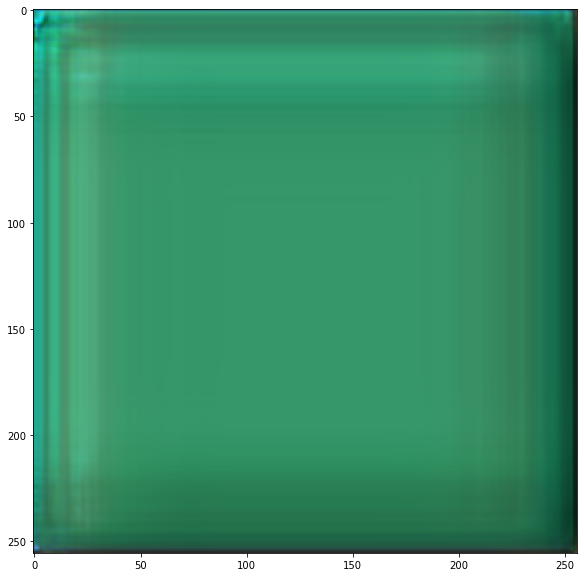

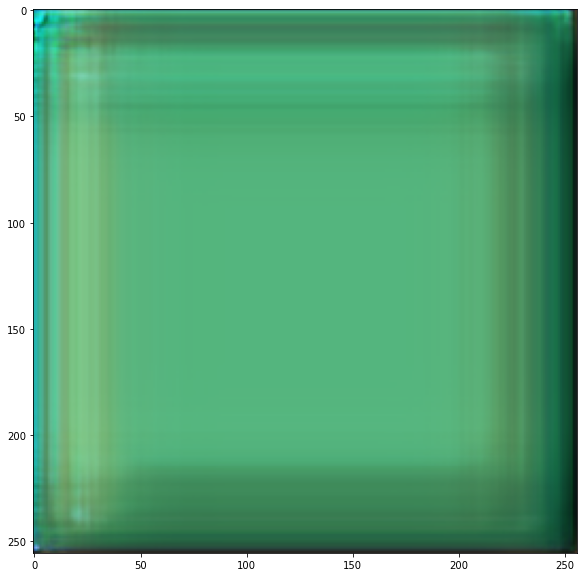

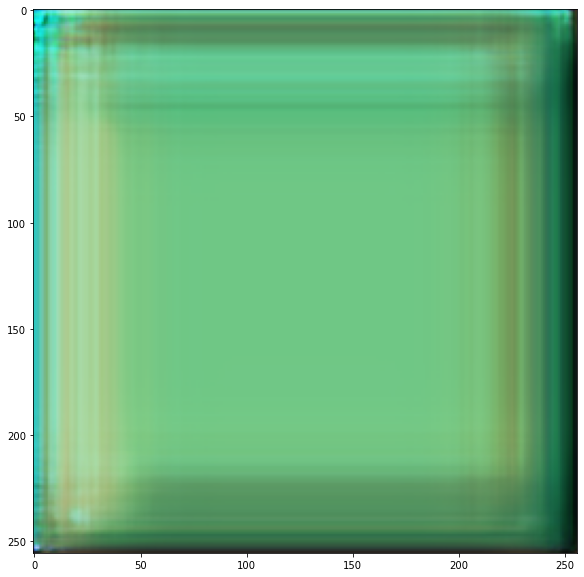

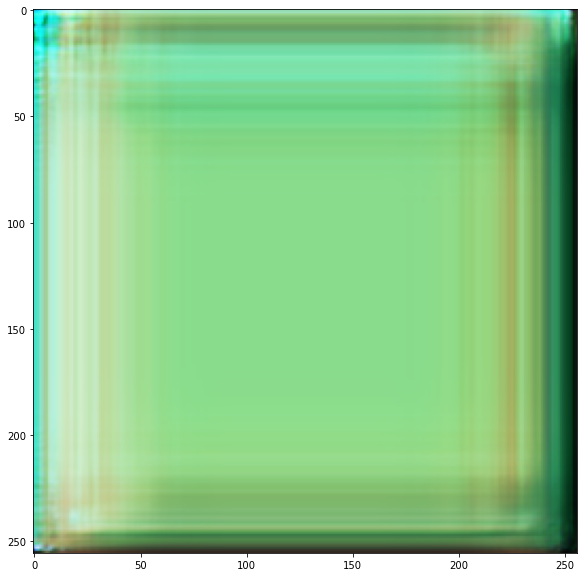

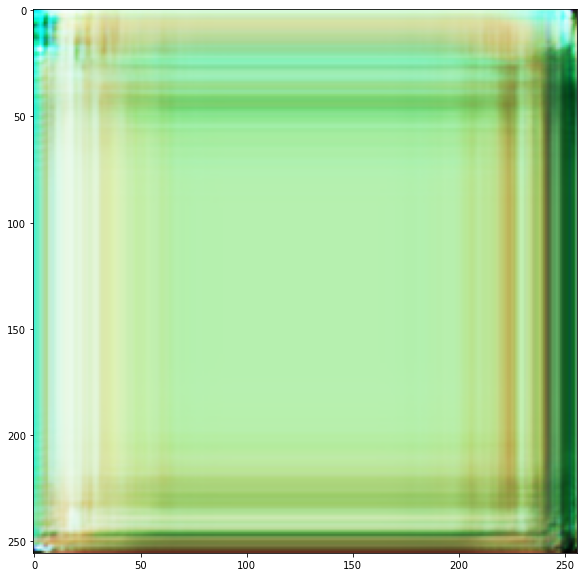

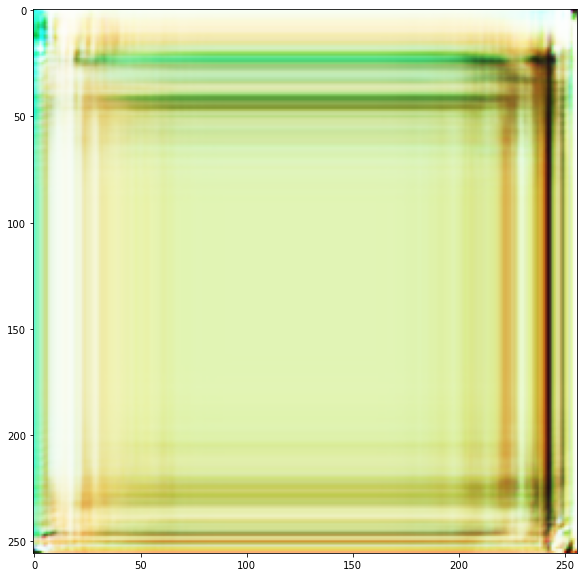

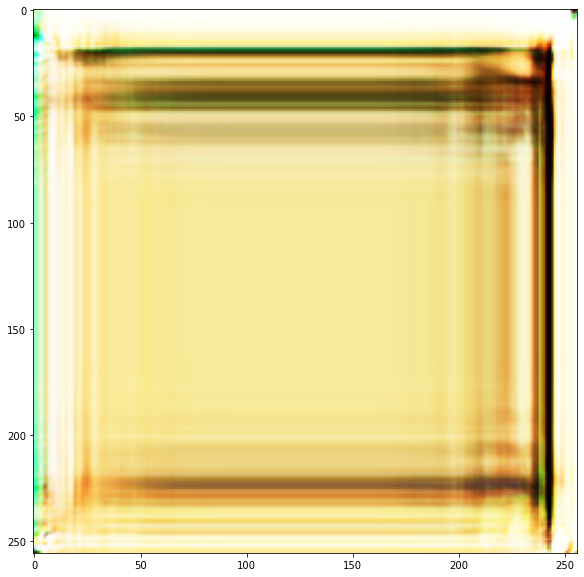

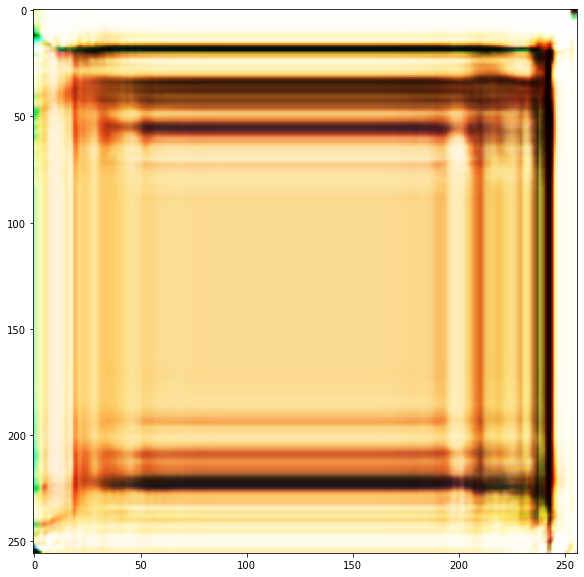

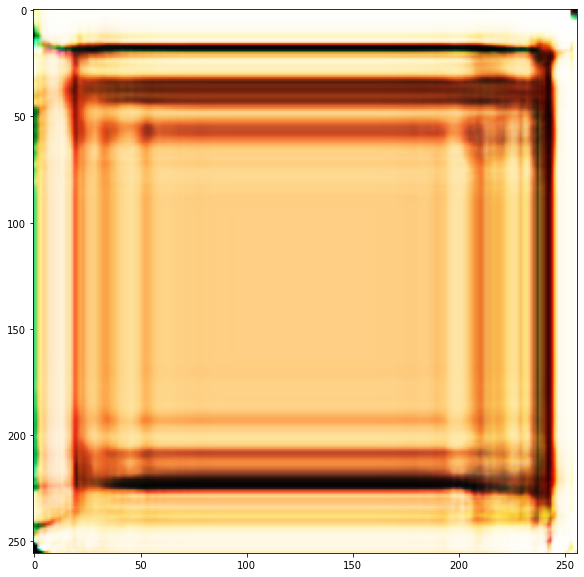

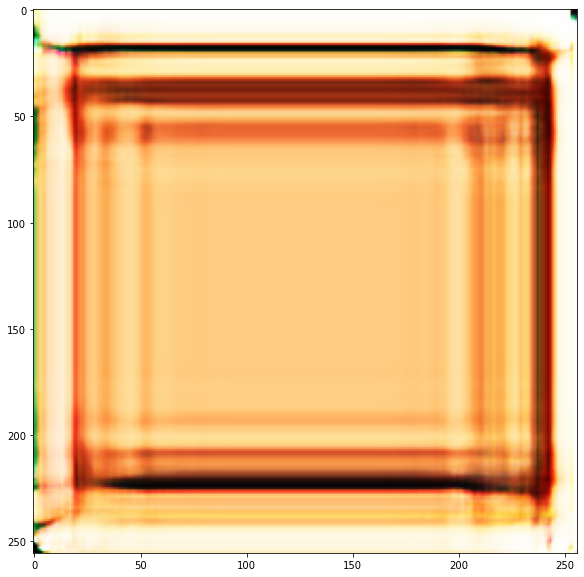

In [13]:
for i in range(1,11):
    data1 = np.zeros((1,256,256,3)) + (i/10)
    predictB = gan.g_AB.predict(data1)
    img_trans = 0.5 * predictB[0,...] + 0.5
    img_trans = np.clip((img_trans * 255).astype(np.uint8), 0, 255)
    plt.figure(figsize=(10,10))
    plt.imshow(img_trans)
    plt.show()

In [14]:
count = 0
for i in data1:
    imgA = i[np.newaxis,...]/127.5 -1
    predictB = gan.g_AB.predict(imgA)
    img_trans = 0.5 * predictB[0,...] + 0.5
    img_trans = np.clip((img_trans * 255).astype(np.uint8), 0, 255)
    plt.imshow(img_trans)
    plt.close()
    cv2.imwrite(os.path.join(r'C:\Users\HW-steve\Documents\GitHub\endo_pytorch_cycleGAN\images\a', 'trans_%04d.png'%count), cv2.cvtColor(img_trans, cv2.COLOR_RGB2BGR))
    count += 1

In [ ]:
save_path = 'images/trans_images/'
img_path = 'images/A/'

img_list = sorted(glob.glob(img_path + '/*.png'))

gan.g_AB.load_weights('saved_model/flip_0831/type1_AB_0110.h5')
gan.g_BA.load_weights('saved_model/flip_0831/type1_BA_0110.h5')

In [ ]:
for i in range(len(img_list)):
    imgA = cv2.cvtColor(cv2.imread(img_list[i]),cv2.COLOR_BGR2RGB)[np.newaxis,...]/127.5 -1
    predictB = gan.g_AB.predict(imgA)
    img_trans = 0.5 * predictB[0,...] + 0.5
    img_trans = np.clip((img_trans * 255).astype(np.uint8), 0, 255)
    plt.imshow(img_trans)
    plt.show()
#     cv2.imwrite(os.path.join(save_path, 'trans_%04d.png'%i), cv2.cvtColor(img_trans, cv2.COLOR_RGB2BGR))

In [ ]:
img_path = '/bong/data/depth_train'
save_path = '/bong/data/type1'
img_list = sorted(glob.glob(img_path + '/*.png'))

In [ ]:
for i in range(len(img_list)):
    imgA = cv2.cvtColor(cv2.imread(img_list[i]),cv2.COLOR_BGR2RGB)[np.newaxis,...]/127.5 -1
    predictB = gan.g_AB.predict(imgA)
    img_trans = 0.5 * predictB[0,...] + 0.5
    img_trans = np.clip((img_trans * 255).astype(np.uint8), 0, 255)
#      plt.imshow(img_trans)
#      plt.show()
    cv2.imwrite(os.path.join(save_path, 'type1_'+os.path.basename(img_list[i].split('.')[0])+'.png'), cv2.cvtColor(img_trans, cv2.COLOR_RGB2BGR))

In [ ]:
for j in range(len(data_file)):
    path = glob.glob(os.path.join(data_path, data_file[j]) + '/*.png')
    up_file_name = 'type1_%04d_'%j
    for i in range(len(path)):
        ori = cv2.imread(path[i])
        img = ori[:,:256,:]
        dep = ori[:,256:,:]
        cv2.imwrite(os.path.join(save_img_path, up_file_name + os.path.basename(path[i])), img)
        cv2.imwrite(os.path.join(save_dep_path, up_file_name + os.path.basename(path[i])), dep)

In [ ]:
img_pathA = 'images/A/0001_image_0456.png'
img_pathB = 'images/B/0000.png'
imgA = cv2.cvtColor(cv2.imread(img_pathA),cv2.COLOR_BGR2RGB)[np.newaxis,...]/127.5 -1
imgB = cv2.cvtColor(cv2.imread(img_pathB),cv2.COLOR_BGR2RGB)[np.newaxis,...]/127.5 -1

In [ ]:
save_path = 'saved_model/flip_0831'
AB_save_list = sorted(glob.glob(save_path + '/type1_AB_*.h5'))
BA_save_list = sorted(glob.glob(save_path + '/type1_BA_*.h5'))

In [ ]:
loss = []
for i in range(len(AB_save_list)):
    gan.g_AB.load_weights(AB_save_list[i])
    gan.g_BA.load_weights(BA_save_list[i])
    predictB = gan.g_AB.predict(imgA)
    predictA = gan.g_BA.predict(predictB)
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.imshow(0.5 * imgA[0,...] + 0.5)
    plt.subplot(1,3,2)
    plt.imshow(0.5 * predictB[0,...] + 0.5)
    plt.subplot(1,3,3)
    plt.imshow(0.5 * predictA[0,...] + 0.5)
    plt.show()
    print('iter :', AB_save_list[i], 'loss :' , np.mean(np.abs(predictA - imgA)))
    loss.append(np.mean(np.abs(predictA - imgA)))

In [ ]:
np.array(loss).min()

In [ ]:
min = [i for i in range(len(loss)) if loss[i] == 0.04742805290815668]

In [ ]:
min

In [ ]:
AB_save_list[98]